In [47]:
# Data handling
import pandas as pd 
import numpy as np

# Clustering
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, normalize

# Dimensionality reduction
from sklearn.decomposition import PCA


# Visualization
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
import matplotlib.style as style
%matplotlib inline

import warnings
warnings.simplefilter("ignore")

In [59]:
def prepare_pca(n_components, data, kmeans_labels):
    """ prepare pca with n dimension
    """
    names = ['x', 'y', 'z']
    matrix = PCA(n_components=n_components).fit_transform(data)
    df_matrix = pd.DataFrame(matrix)
    df_matrix.rename({i:names[i] for i in range(n_components)}, axis=1, inplace=True)
    df_matrix['labels'] = kmeans_labels
    
    return df_matrix

def plot_3d(df, name='labels'):
    """ plot 3d scatter
    """
    iris = px.data.iris()
    fig = px.scatter_3d(df, x='x', y='y', z='z',color=name)
    fig.update_traces(marker=dict(size=3))
    fig.show()
    
    
def load_preprocess_data():
    """ Load and preprocess data
    """
    # load dataset
    df = pd.read_csv('data_credit_card_customer_seg.csv')
    
    # handle missing values by replace it by means
    df['CREDIT_LIMIT'].fillna(df['CREDIT_LIMIT'].mean(), inplace=True)
      
    
    # drop unnecessary column
    df.drop('CUST_ID', axis=1, inplace=True)
    
    return  df

df = load_preprocess_data()
df.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,864.206542,0.000000,12
4,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


## Data Normalization

In [60]:
scaler = StandardScaler() 
scaled_df = scaler.fit_transform(df) 

In [61]:
# Normalizing the Data 
normalized_df = normalize(scaled_df) 
  
# Converting the numpy array into a pandas DataFrame 
normalized_df = pd.DataFrame(normalized_df) 

## Dimension Reduction using PCA

In [62]:
pca = PCA(n_components = 2) 
X_principal = pca.fit_transform(normalized_df) 
X_principal = pd.DataFrame(X_principal) 
X_principal.columns = ['P1', 'P2'] 
X_principal.head(2)

,P1,P2
0,-0.489826,-0.679678
1,-0.518791,0.545011


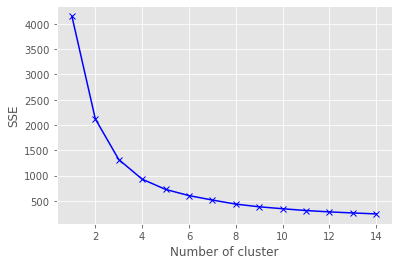

In [63]:
style.use('ggplot')

# Choosing the K value using elbow method 
sse = {}
for k in range(1, 15):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(X_principal)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()),'bx-')
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

It's hard to find the elbow point of the curve, so we use silhouette score.

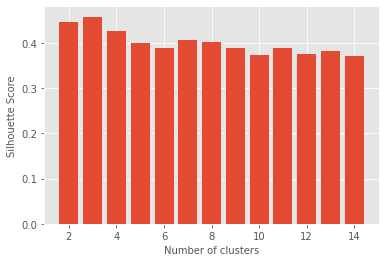

In [64]:
# silhouette score
silhouette_scores = []

for n_cluster in range(2, 15):
    silhouette_scores.append( 
        silhouette_score(X_principal, KMeans(n_clusters = n_cluster).fit_predict(X_principal))) 
    
# Plotting a bar graph to compare the results 
k = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14] 

plt.bar(k, silhouette_scores) 
plt.xlabel('Number of clusters', fontsize = 10) 
plt.ylabel('Silhouette Score', fontsize = 10) 
plt.show() 

Highest silhouette score is k = 3.

# Kmeans clustering

Let's visualize k=3,4

## k=4

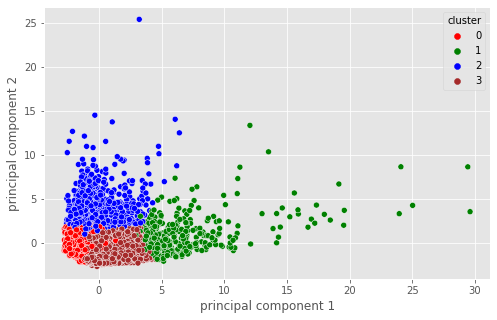

In [65]:
# Kmeans algorithm
kmean= KMeans(n_clusters=4,init='k-means++',n_init=10)
kmean.fit(scaled_df)
labels=kmean.labels_

# PCA to transform data to 2 dimensions for visualization
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(scaled_df)
principalDf = pd.DataFrame(data = principalComponents, columns=['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, pd.DataFrame({'cluster':labels})], axis = 1)

# scatterplot
plt.figure(figsize=(8,5))
ax = sns.scatterplot(x="principal component 1", y="principal component 2", hue="cluster", data=finalDf,palette=['red','green','blue','brown'])
plt.show()

In [71]:
#3D plot
pca_df = prepare_pca(3, scaled_df, labels)
plot_3d(pca_df)

In [66]:
clusters=pd.concat([df, pd.DataFrame({'cluster':labels})], axis=1)
clusters['cluster'].value_counts()

0    3977
3    3366
2    1198
1     409
Name: cluster, dtype: int64

In [67]:
clusters.groupby('cluster').mean()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
cluster,,,,,,,,,,,,,,,,,
0,1011.839396,0.789924,270.144981,209.932625,60.479311,596.300906,0.170250,0.086301,0.080662,0.114888,2.125974,2.907468,3277.256169,975.330332,586.261175,0.078002,11.446568
1,3551.153761,0.986879,7681.620098,5095.878826,2587.208264,653.638891,0.946418,0.739031,0.788060,0.071290,2.085575,89.359413,9696.943765,7288.739497,1976.815179,0.286707,11.951100
2,4602.462714,0.968415,501.896219,320.373681,181.607404,4520.724309,0.287731,0.138934,0.185516,0.484526,14.284641,7.661102,7546.957050,3481.145990,2008.251157,0.034859,11.387312
3,894.768927,0.934715,1236.263333,593.995933,642.541696,209.816318,0.885255,0.297109,0.711930,0.042487,0.789067,22.092692,4214.013741,1331.325429,650.233383,0.269313,11.594474


Text(0.5, 0, 'SEGMENTS')

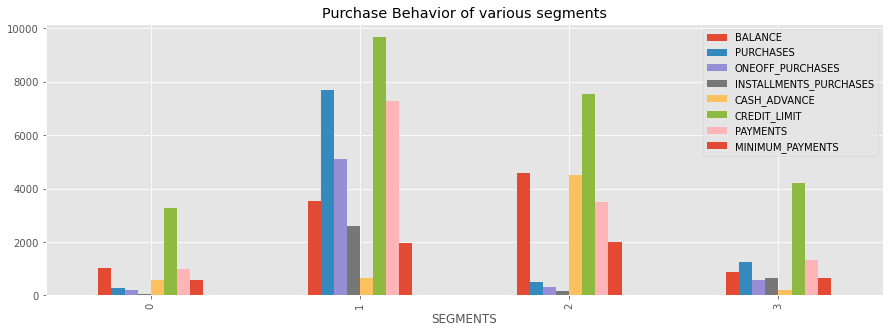

In [72]:
(clusters[['BALANCE', 'PURCHASES', 'ONEOFF_PURCHASES',
           'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE','CREDIT_LIMIT', 'PAYMENTS', 
           'MINIMUM_PAYMENTS', 'cluster']]
 .groupby('cluster').mean().plot.bar(figsize=(15, 5)))
plt.title('Purchase Behavior of various segments')
plt.xlabel('SEGMENTS')

### Conclusion


* **Cluster 0 :** This customer group indicates a large group of customers who have low balances, small spenders (low purchase) with the lowest credit limit. 

* **Cluster 1 :** This customer group indicates a small group of customers who have medium balances, spenders (high purchase) with the highest credit limit.

* **Cluster 2 :** This customer group indicates a small group of customers who have high balances and cash advances, low purchase frequency with high credit limit. We can assume that this customer segment uses their credit cards as a loan.

* **Cluster 3 :** This customer group indicates a large group of customers who have low balances, good purchase frequency with installment purchases. We can assume that this customer segment purchases with installment